<a href="https://colab.research.google.com/github/ielgstrom/Practica-2/blob/main/Codi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
# No es pot muntar el drive des de r per tant el que pots fer de mentres es:
# 1. A la carpeta d'arxius del menu esquerra donar click
# 2. Afegir l'arxiu del drive manualment.
# M'hi he barallat una estona i no veig manera mes eficient de moment

In [139]:
# Farem servir el paquet countrycode per obtenir el continent on es situa cada
# país a partir del codi ISO - alpha 2.
install.packages('countrycode')
install.packages('missForest')
install.packages('caret')
install.packages('performanceEstimation')
install.packages("dbscan")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [140]:
library('caret')
library('dplyr')
library('e1071')
library('tidyverse')
library('missForest')
library('countrycode')
library('randomForest')
library('performanceEstimation')
library('dbscan')

In [141]:
# Guardem el dataset obtingut a la pràctica anterior:
data_frame <- read.csv('dataset.csv',na.strings='')
head(data_frame)

,Pais,Fecha,SMI.Mon..Local,SMI,Deute.Total,Deute.PIB,Deute.Per.Capita,Dèficit,Dèficit.PIB,Atur,PIB.anual,Var..PIB....,IPC.Anual.General,Codi
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,Afganistán,2023,5500.0,NA,NA,NA,NA,-218,-1.36,NA,16022,2.7,NA,AF
2,Albania,2023,37000.0,393.35,NA,NA,NA,NA,NA,NA,21255,3.4,NA,AL
3,Alemania,2023,1997.0,2146.35,2631777,62.9,31539,-107522,-2.60,"3,2",4185550,-0.3,3.7,DE
4,Alemania,2023,1997.0,2146.35,2631777,62.9,31539,-107522,-2.60,"3,2",4185550,-0.3,3.7,DE
5,Andorra,2023,1286.1,1371.80,1255,36.4,14747,79,2.30,NA,3448,1.4,4.6,AD
6,Angola,2023,32181.2,47.00,NA,NA,NA,NA,NA,NA,82929,0.9,20.0,AO


1. Descripció del dataset.

Fem una petita descripció del dataset amb els maxims minims i els valors nuls d'aquest:


In [142]:
summary(data_frame)

     Pais               Fecha      SMI.Mon..Local          SMI        
 Length:233         Min.   :2016   Min.   :       1   Min.   :   1.6  
 Class :character   1st Qu.:2023   1st Qu.:    1203   1st Qu.: 183.2  
 Mode  :character   Median :2023   Median :    3673   Median : 369.9  
                    Mean   :2023   Mean   :  584539   Mean   : 674.0  
                    3rd Qu.:2023   3rd Qu.:   35000   3rd Qu.: 849.7  
                    Max.   :2023   Max.   :53073300   Max.   :4626.4  
                    NA's   :7      NA's   :100        NA's   :115     
  Deute.Total         Deute.PIB      Deute.Per.Capita    Dèficit        
 Min.   :       5   Min.   :  2.33   Min.   :   180   Min.   :-1811546  
 1st Qu.:    8536   1st Qu.: 39.51   1st Qu.:  1469   1st Qu.:  -11448  
 Median :   40386   Median : 54.54   Median :  4184   Median :   -1470  
 Mean   :  652980   Mean   : 60.25   Mean   : 11986   Mean   :  -38818  
 3rd Qu.:  200409   3rd Qu.: 77.94   3rd Qu.: 14888   3rd Qu.:    -

2. Integració i selecció de les dades:  

Primer de tot, ens quedarem amb unes quantes de les columnes del dataset original. Eliminarem les següents: SMI.Mon.Local, ja que aporta la mateixa informació que SMI (USD), i així els valors són comparables entre tots els paisos.

També eliminarem Deute.PIB, i Dèficit.PIB i ens quedarem amb les columnes Deute.Total, Deute.Per.Capita, Dèficit i PIB.anual. Fem això ja que les columnes Deute.PIB i Dèficit.PIB estan clarament correlacionades amb Duete, Dèficit i PIB.anual.

De moment mantindrem Codi, ja que ens anirà bé per a la preparació de les dades, però després el traurem, ja que dona la mateixa informació que Pais.

In [143]:
data <- data_frame[,c('Pais', 'Fecha', 'SMI', 'Deute.Total', 'Deute.Per.Capita', 'Dèficit', 'Atur', 'PIB.anual', 'Var..PIB....', 'IPC.Anual.General', 'Codi')]

In [144]:
# Simplificarem alguns dels noms de les columnes:
names(data)[names(data) == 'Deute.Total'] <- 'Deute'
names(data)[names(data) == 'Deute.Per.Capita'] <- 'Deute.Capita'
names(data)[names(data) == 'Dèficit'] <- 'Deficit'
names(data)[names(data) == 'PIB.anual'] <- 'PIB'
names(data)[names(data) == 'Var..PIB....'] <- 'PIB.Var'
names(data)[names(data) == 'IPC.Anual.General'] <- 'IPC'
head(data)

,Pais,Fecha,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC,Codi
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,Afganistán,2023,NA,NA,NA,-218,NA,16022,2.7,NA,AF
2,Albania,2023,393.35,NA,NA,NA,NA,21255,3.4,NA,AL
3,Alemania,2023,2146.35,2631777,31539,-107522,"3,2",4185550,-0.3,3.7,DE
4,Alemania,2023,2146.35,2631777,31539,-107522,"3,2",4185550,-0.3,3.7,DE
5,Andorra,2023,1371.80,1255,14747,79,NA,3448,1.4,4.6,AD
6,Angola,2023,47.00,NA,NA,NA,NA,82929,0.9,20.0,AO


Afegirem una columna per indicar el continent en el qual es troba cada país. Aquesta columna serà la variable objectiu.

In [145]:
# Creem una nova columna, Continent, on a partir de la columna Codi
# extraiem el continent. Així, ndiquem que l'origen de les dades és iso2c
# i el destí continent.
data$Continent <- countrycode(sourcevar = data[, "Codi"],
                            origin = "iso2c",
                            destination = "continent")

Warning message:
“Some values were not matched unambiguously: EA
”


In [146]:
# Eliminem les files corresponents a la zona Euro (EA), ja que
# només ens interessa estudiar paisos:

In [147]:
data <- data[ !(data$Pais == 'Zona Euro'), ]

In [148]:
# Mirem si hi ha algun país amb continent NA:
data[which(is.na(data$Continent)), ]

Pais,Fecha,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC,Codi,Continent
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>


In [149]:
# Comprovem que el resultat ha sigut satisfactori:
head(data)

,Pais,Fecha,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC,Codi,Continent
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,Afganistán,2023,NA,NA,NA,-218,NA,16022,2.7,NA,AF,Asia
2,Albania,2023,393.35,NA,NA,NA,NA,21255,3.4,NA,AL,Europe
3,Alemania,2023,2146.35,2631777,31539,-107522,"3,2",4185550,-0.3,3.7,DE,Europe
4,Alemania,2023,2146.35,2631777,31539,-107522,"3,2",4185550,-0.3,3.7,DE,Europe
5,Andorra,2023,1371.80,1255,14747,79,NA,3448,1.4,4.6,AD,Europe
6,Angola,2023,47.00,NA,NA,NA,NA,82929,0.9,20.0,AO,Africa


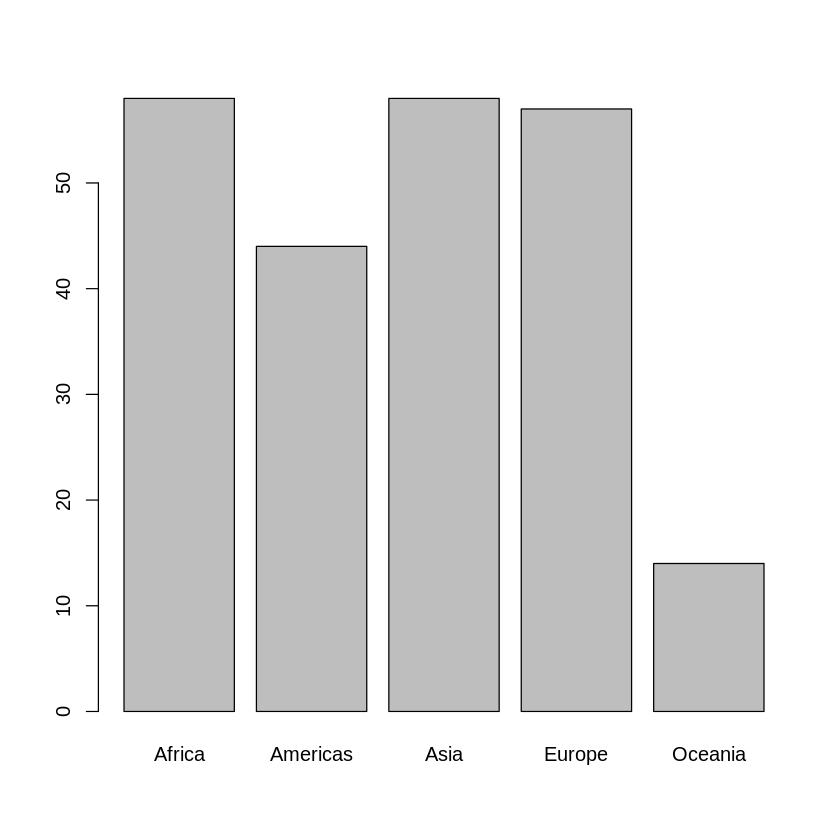

In [150]:
# Estudiem la distribució de continents:
barplot(table(data$Continent))

In [151]:
# Observem que Oceania té molts pocs països, en comparació a la resta.
# Sabem que això és problemàtic a l'hora d'analitzar les dades, tant per mètodes
# supervisats com no supervisats. Aplicar tècniques de random oversampling
# pot ser útil per augmentar les dades dels altres continents, i que
# tots tinguin com Àfrica, per exemple, però amb Oceania hi ha molta diferència.

# Per tant, el que farem serà eliminar aquests valors del dataframe.
data <- data[ !(data$Continent == 'Oceania'), ]

In [152]:
# Mirem quants nuls tenim:
colSums(is.na(data))

Pais        Fecha          SMI        Deute Deute.Capita      Deficit 
           0            7          105           71           71           68 
        Atur          PIB      PIB.Var          IPC         Codi    Continent 
         165           32           32          112            0            0

In [153]:
# Com que per algunes columnes tenim un nombre de nuls molt elevat,
# hem decidit que buscarem algunes de les dades que falten per afegir-les
# directament, i així tenir més valors fiables. Ho farem per les columnes
# SMI, Atur i IPC, que són les columnes amb més valors faltants.

# Pels altres valors faltants, després aplicarem altres mètodes d'imputació.
# Així tenim les dues

# Carreguem les dades noves:
data_smi <- read.csv('smi_data.csv', na.strings='', sep=';')
data_atur <- read.csv('atur_data.csv', na.strings='', sep=';')
data_ipc <- read.csv('ipc_data.csv', na.strings='', sep=';')

In [154]:
# Com que els noms dels països estan en anglès, afegirem una columna amb el
# codi de cada país, per poder-los associar després al nostre conjunt de dades.
data_smi$Codi <- countrycode(sourcevar = data_smi[, "Pais"],
                            origin = "country.name",
                            destination = "iso2c")
data_atur$Codi <- countrycode(sourcevar = data_atur[, "Pais"],
                            origin = "country.name",
                            destination = "iso2c")
data_ipc$Codi <- countrycode(sourcevar = data_ipc[, "Pais"],
                            origin = "country.name",
                            destination = "iso2c")

In [155]:
data_smi <- data_smi[,c('Codi', 'SMI')]
data_atur <- data_atur[,c('Codi', 'Atur')]
data_ipc <- data_ipc[,c('Codi', 'IPC')]

In [156]:
# Per tenir dades més consistents, en comptes d'agafar només els valors que
# falten, substituirem tots els valors de cada columna, així tindrem que
# cada columna prové de la mateixa font d'informació.
data <- dplyr::rows_update(data, data_smi, unmatched = 'ignore')
data <- dplyr::rows_update(data, data_atur, unmatched = 'ignore')
data <- dplyr::rows_update(data, data_ipc, unmatched = 'ignore')

Matching, by = "Codi"
Matching, by = "Codi"
Matching, by = "Codi"


In [157]:
# Comprovem que hem reduït molt el nombre de valors nuls per aquestes columnes:
colSums(is.na(data))

Pais        Fecha          SMI        Deute Deute.Capita      Deficit 
           0            7           36           71           71           68 
        Atur          PIB      PIB.Var          IPC         Codi    Continent 
           0           32           32           42            0            0

In [158]:
# Mirem la classe de cada columna:
sapply(data, class)

Pais        Fecha          SMI        Deute Deute.Capita      Deficit 
 "character"    "integer"    "numeric"    "numeric"    "numeric"    "numeric" 
        Atur          PIB      PIB.Var          IPC         Codi    Continent 
 "character"    "numeric"    "numeric"    "numeric"  "character"  "character"

In [159]:
# Corregim la variable Atur perque interpreti com a numèric:
data$Atur <- gsub(",", ".", data$Atur)
data$Atur <- as.numeric(data$Atur)
sapply(data, class)

Pais        Fecha          SMI        Deute Deute.Capita      Deficit 
 "character"    "integer"    "numeric"    "numeric"    "numeric"    "numeric" 
        Atur          PIB      PIB.Var          IPC         Codi    Continent 
   "numeric"    "numeric"    "numeric"    "numeric"  "character"  "character"

In [160]:
head(data)

,Pais,Fecha,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC,Codi,Continent
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,Afganistán,2023,71.50,NA,NA,-218,14.39,16022,2.7,NA,AF,Asia
2,Albania,2023,386.42,NA,NA,NA,11.00,21255,3.4,NA,AL,Europe
3,Alemania,2023,2544.08,2631777,31539,-107522,3.29,4185550,-0.3,5.95,DE,Europe
4,Alemania,2023,2544.08,2631777,31539,-107522,3.29,4185550,-0.3,5.95,DE,Europe
5,Andorra,2023,1521.08,1255,14747,79,1.50,3448,1.4,NA,AD,Europe
6,Angola,2023,55.25,NA,NA,NA,8.50,82929,0.9,13.64,AO,Africa


In [161]:
# Hi ha files repetides idènticament, com la d'Alemanya. Eliminem-les:
data <- distinct(data)
head(data)

,Pais,Fecha,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC,Codi,Continent
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,Afganistán,2023,71.50,NA,NA,-218,14.39,16022,2.7,NA,AF,Asia
2,Albania,2023,386.42,NA,NA,NA,11.00,21255,3.4,NA,AL,Europe
3,Alemania,2023,2544.08,2631777,31539,-107522,3.29,4185550,-0.3,5.95,DE,Europe
4,Andorra,2023,1521.08,1255,14747,79,1.50,3448,1.4,NA,AD,Europe
5,Angola,2023,55.25,NA,NA,NA,8.50,82929,0.9,13.64,AO,Africa
6,Antigua y Barbuda,2023,526.42,1452,14375,-32,11.00,1880,3.9,5.07,AG,Americas


In [162]:
# Observem els útlims valors:
tail(data, 8)

,Pais,Fecha,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC,Codi,Continent
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
197,Venezuela,2018,0.86,NA,NA,NA,6.40,NA,NA,NA,VE,Americas
198,Venezuela,2023,0.86,NA,NA,NA,6.40,NA,NA,NA,VE,Americas
199,Viet Nam,2023,132.58,NA,NA,NA,2.06,400989,5.0,3.25,VN,Asia
200,Yemen,NA,NA,NA,NA,NA,13.60,NA,NA,NA,YE,Asia
201,Yibuti,2023,NA,1283,1281,-125,27.93,3790,6.7,1.50,DJ,Africa
202,Zambia,2023,49.67,NA,NA,NA,13.00,26022,5.8,10.88,ZM,Africa
203,Zimbabue,2021,NA,NA,NA,NA,5.20,NA,NA,NA,ZW,Africa
204,Zimbabue,2023,NA,31498,1969,-2033,5.20,32745,5.0,NA,ZW,Africa


In [163]:
# Veiem que hi ha files diferents que corresponen al mateix país, però
# diferents anys. Això és degut a que quan obteníem les dades de la web, sempre
# agafavem el valor més actualitzat. Per la majoria de països, les dades
# estaven actualitzades i tenim tota la informació de l'any
# 2023. Per altres països teníem columnes d'aquest any, i columnes d'altres
# anys, ja que era l'última informació disponible.

# Com que el que ens interessa és tenir les últimes dades disponibles, encara
# que potser no siguin totes de l'any 2023, el que farem serà ajuntar les files
# corresponents al mateix país, i eliminarem la columna Fecha. Així tindrem
# la informació més recent disponible per a cada país.

In [164]:
# Primer de tot eliminarem tots aquells paisos que no tinguin dades,
# és a dir, aquells que no tenen valor a la columna Fecha.
data <- data[!is.na(data$Fecha),]

In [165]:
# Com que ara no té sentit guardar la columna Fecha, ja que les dades no són
# del mateix any, si no de l'any disponible, eliminarem la columna Fecha.
# També eliminarem la columna Codi, ja que aporta la mateixa informació que
# la columna Pais.

# Eliminem les columnes Fecha i Codi:
data <- data[,c('Pais', 'SMI', 'Deute', 'Deute.Capita', 'Deficit', 'Atur', 'PIB', 'PIB.Var', 'IPC', 'Continent')]

In [166]:
# Procedim a ajuntar les files amb valors faltants.

# Solució extreta de:
# https://stackoverflow.com/questions/45515218/combine-rows-in-data-frame-containing-na-to-make-complete-row

coalesce_by_column <- function(data) {
  return(coalesce(data[1], data[2]))
}

data <- data %>%
  group_by(Pais, Continent) %>%
  summarise_all(coalesce_by_column)

In [167]:
# Comprovem que ara és correcte:
tail(data, 8)

Pais,Continent,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Uganda,Africa,35.50,24106,568,-2300,2.90,47239,4.6,5.35
Uruguay,Americas,511.33,46062,12957,-2197,8.09,71415,0.4,5.87
Uzbekistán,Asia,86.75,30538,848,-3774,7.85,93922,6.3,NA
Venezuela,Americas,0.86,NA,NA,NA,6.40,NA,NA,NA
Viet Nam,Asia,132.58,NA,NA,NA,2.06,400989,5.0,3.25
Yibuti,Africa,NA,1283,1281,-125,27.93,3790,6.7,1.50
Zambia,Africa,49.67,NA,NA,NA,13.00,26022,5.8,10.88
Zimbabue,Africa,NA,31498,1969,-2033,5.20,32745,5.0,NA


A falta de variables categoriques, en crearem a través de la discretització. Per afegir variables categòriques, substituirem els valors de les variables IPC, Atur i PIB.Var per valor categòrics.

In [168]:
colSums(is.na(data))

Pais    Continent          SMI        Deute Deute.Capita      Deficit 
           0            0           29           41           41           38 
        Atur          PIB      PIB.Var          IPC 
           0            3            3           31

Comencem per discretitzar la columna Atur. Veiem com es distribueixen els valors en aquesta columna, per entendre quins intervals té sentit definir:

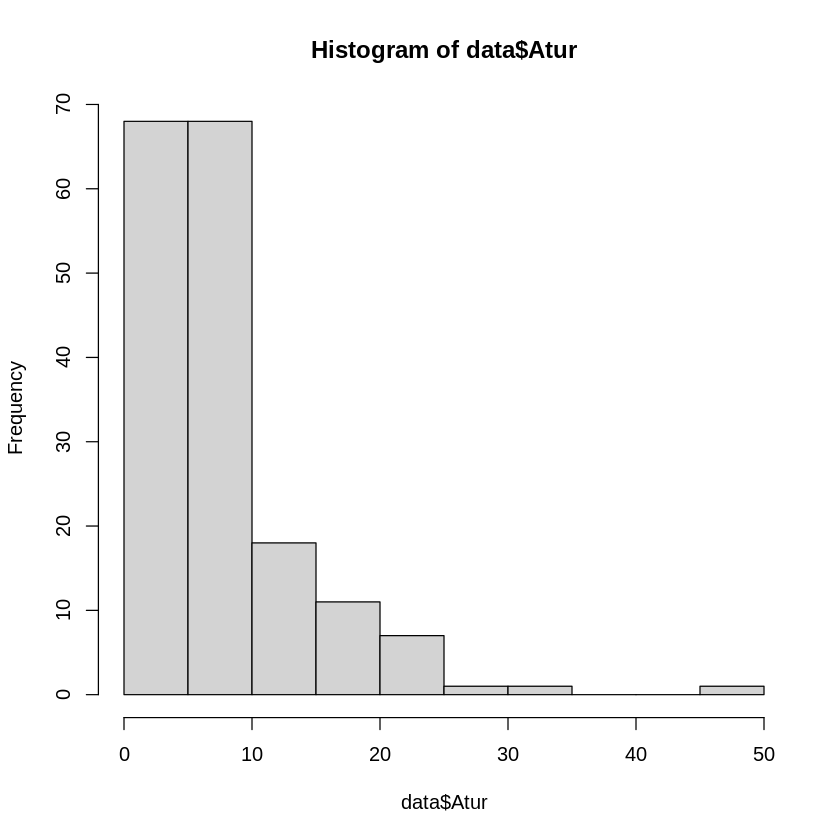

In [169]:
# Fem un histograma:
hist(data$Atur, breaks= 13)

In [170]:
# Definirem 4 trams, Baix, Moderat, Elevat i Massiu:
tall_atur = c(0,5,10,20,Inf)
data$Atur <- cut(data$Atur, breaks = tall_atur, labels = c('Baix', 'Moderat', 'Elevat', 'Massiu'), right = F)

In [171]:
head(data)

Pais,Continent,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
Afganistán,Asia,71.50,NA,NA,-218,Elevat,16022,2.7,NA
Albania,Europe,386.42,NA,NA,NA,Elevat,21255,3.4,NA
Alemania,Europe,2544.08,2631777,31539,-107522,Baix,4185550,-0.3,5.95
Andorra,Europe,1521.08,1255,14747,79,Baix,3448,1.4,NA
Angola,Africa,55.25,NA,NA,NA,Moderat,82929,0.9,13.64
Antigua y Barbuda,Americas,526.42,1452,14375,-32,Elevat,1880,3.9,5.07


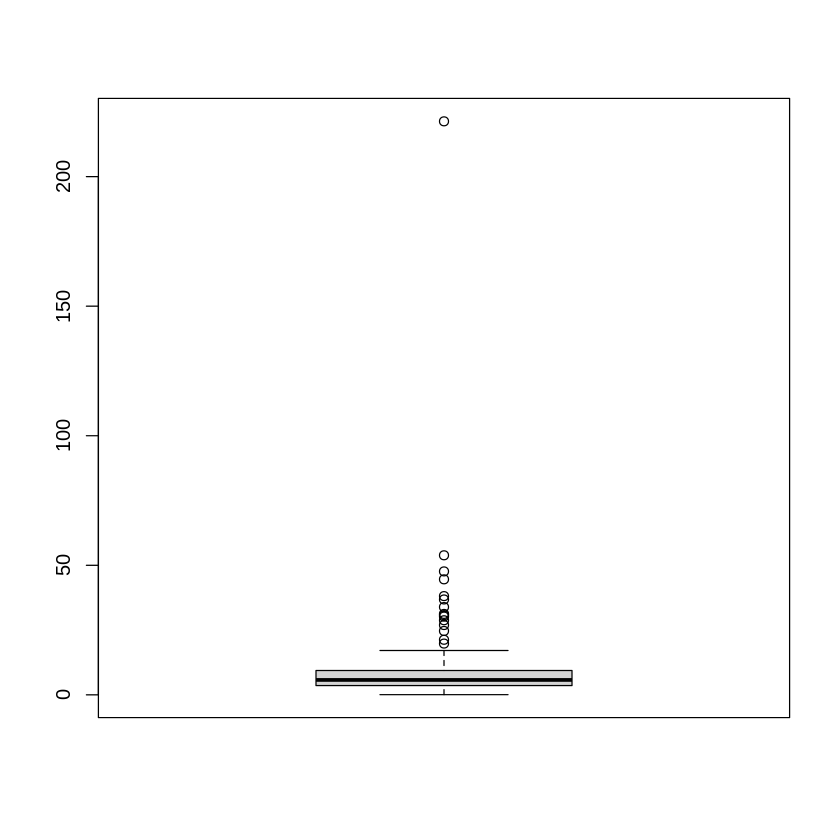

In [172]:
# Estudiem el mateix per a l'IPC:
boxplot(data$IPC)

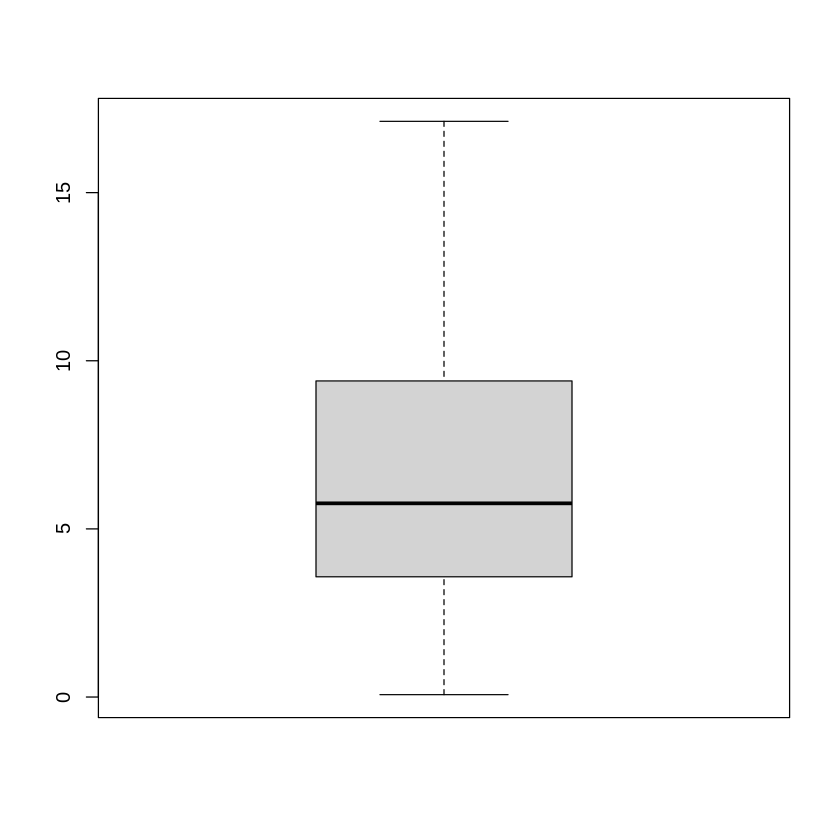

In [173]:
boxplot(data$IPC, outline = FALSE)

In [174]:
min(data$IPC, na.rm=T)

[1] 0.07

In [175]:
max(data$IPC, na.rm=T)

[1] 221.34

In [176]:
# Definirem 4 trams, Baix, Moderat, Elevat i Massiu:
tall_ipc = c(0,6,10,17,Inf)
data$IPC <- cut(data$IPC, breaks = tall_ipc, labels = c('Baix', 'Moderat', 'Elevat', 'Massiu'), right = F)

In [177]:
head(data)

Pais,Continent,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>
Afganistán,Asia,71.50,NA,NA,-218,Elevat,16022,2.7,NA
Albania,Europe,386.42,NA,NA,NA,Elevat,21255,3.4,NA
Alemania,Europe,2544.08,2631777,31539,-107522,Baix,4185550,-0.3,Baix
Andorra,Europe,1521.08,1255,14747,79,Baix,3448,1.4,NA
Angola,Africa,55.25,NA,NA,NA,Moderat,82929,0.9,Elevat
Antigua y Barbuda,Americas,526.42,1452,14375,-32,Elevat,1880,3.9,Baix


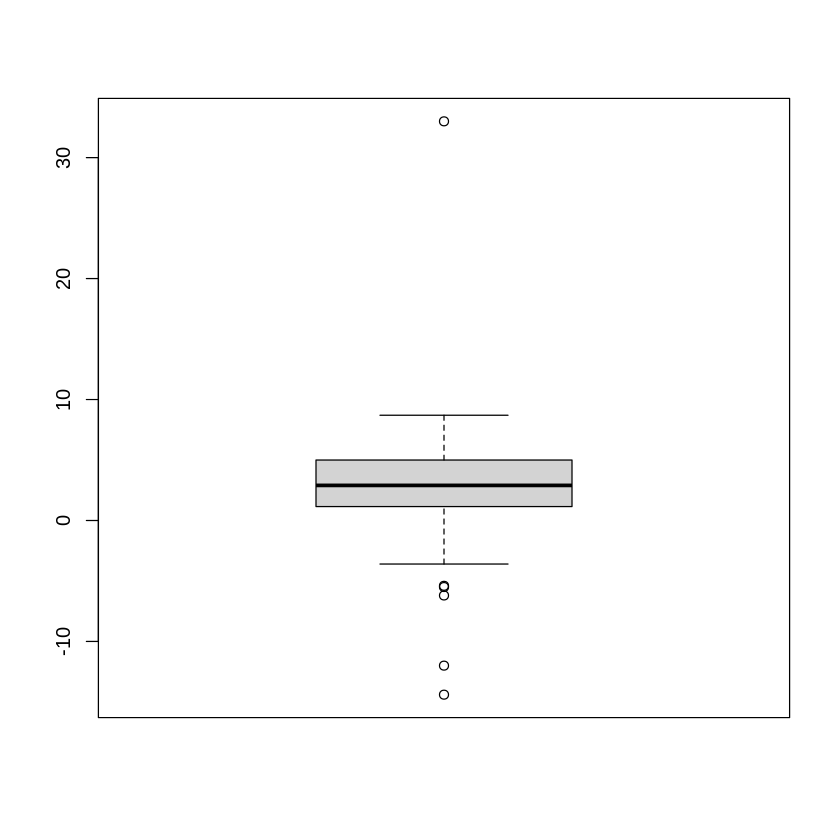

In [178]:
# Estudiem el mateix per a PIB.Var:
boxplot(data$PIB.Var)

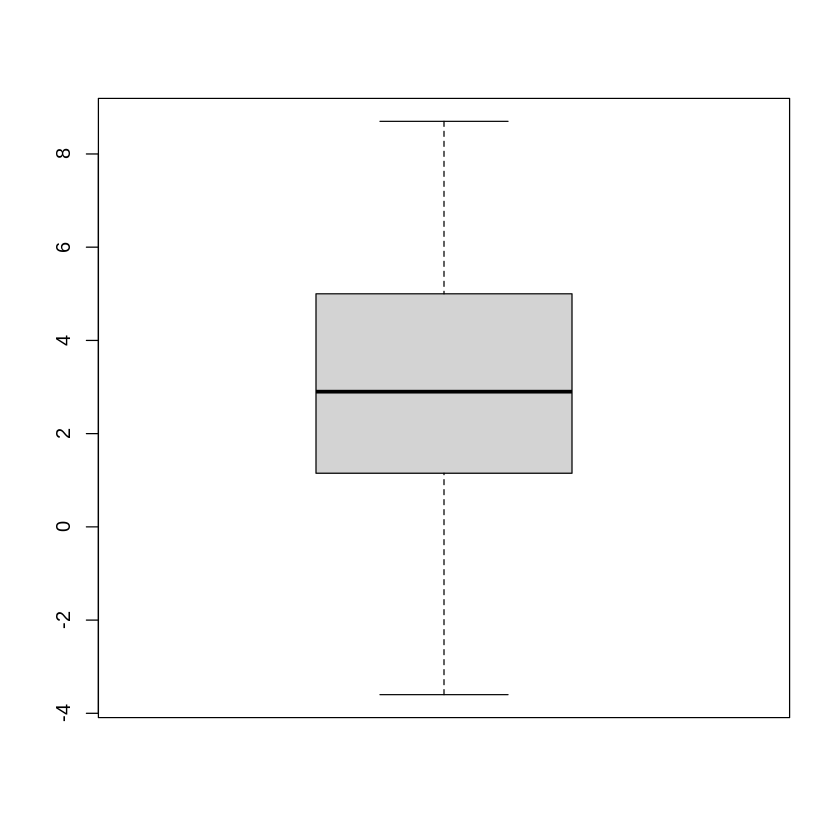

In [179]:
boxplot(data$PIB.Var, outline = F)

In [180]:
# Definirem 4 trams, Negatiu, Baix, Moderat i Elevat:
tall_pib = c(-Inf,0,3,6,Inf)
data$PIB.Var <- cut(data$PIB.Var, breaks = tall_pib, labels = c('Negatiu', 'Baix', 'Moderat', 'Elevat'), right = F)

In [181]:
# Es demana fer una descripció breu del dataset:
# head(data, n= 10)

# Observem que ja tenim les variables categòriques definides en format factor:
sapply(data, class)

Pais    Continent          SMI        Deute Deute.Capita      Deficit 
 "character"  "character"    "numeric"    "numeric"    "numeric"    "numeric" 
        Atur          PIB      PIB.Var          IPC 
    "factor"    "numeric"     "factor"     "factor"

In [182]:
## Fem els paisos com a indexos del df
data <- as.data.frame(data)
rownames(data) <- data$Pais
data <- data[,-1]
head(data)

,Continent,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
Afganistán,Asia,71.50,NA,NA,-218,Elevat,16022,Baix,NA
Albania,Europe,386.42,NA,NA,NA,Elevat,21255,Moderat,NA
Alemania,Europe,2544.08,2631777,31539,-107522,Baix,4185550,Negatiu,Baix
Andorra,Europe,1521.08,1255,14747,79,Baix,3448,Baix,NA
Angola,Africa,55.25,NA,NA,NA,Moderat,82929,Baix,Elevat
Antigua y Barbuda,Americas,526.42,1452,14375,-32,Elevat,1880,Moderat,Baix


3 Neteja de dades

Ens hem quedat amb les següents variables:
  - Pais
  - Continent
  - SMI
  - Deute
  - Deute.Capita
  - Deficit
  - Atur
  - PIB
  - PIB.Var
  - IPC

A continuació, acabarem de fer-ne la neteja.



3.2 Tipus dels atributs

In [183]:
# Mirem primer les classes de cada columna:
sapply(data, class)

Continent          SMI        Deute Deute.Capita      Deficit         Atur 
 "character"    "numeric"    "numeric"    "numeric"    "numeric"     "factor" 
         PIB      PIB.Var          IPC 
   "numeric"     "factor"     "factor"

In [184]:
# Ja s'han convertit moltes variables categòriques a factor al llarg del procés.
# Només ens falta convertir Continent a factor.
# La resta de variables ja tenen el format apropiat:
data$Continent <- as.factor(data$Continent)
# Comfirmem els canvis:
sapply(data, class)

Continent          SMI        Deute Deute.Capita      Deficit         Atur 
    "factor"    "numeric"    "numeric"    "numeric"    "numeric"     "factor" 
         PIB      PIB.Var          IPC 
   "numeric"     "factor"     "factor"

3.3 Valors extrems

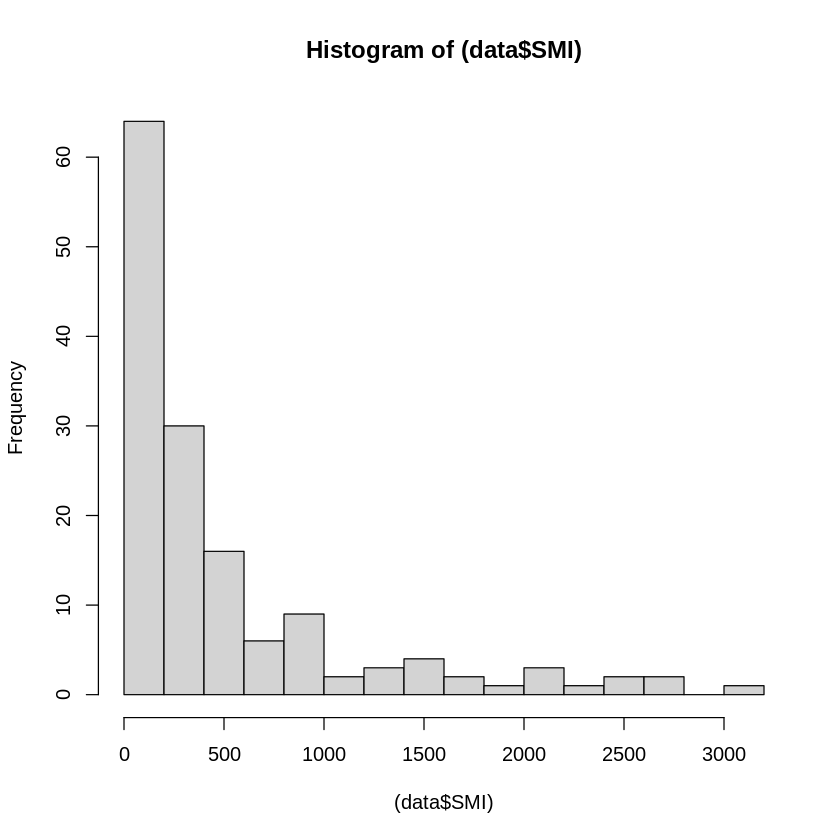

In [185]:
# Anem observant les variables i veiem si ens trobem amb algun extrem.

# Mirem la variable SMI
hist((data$SMI), breaks=15)

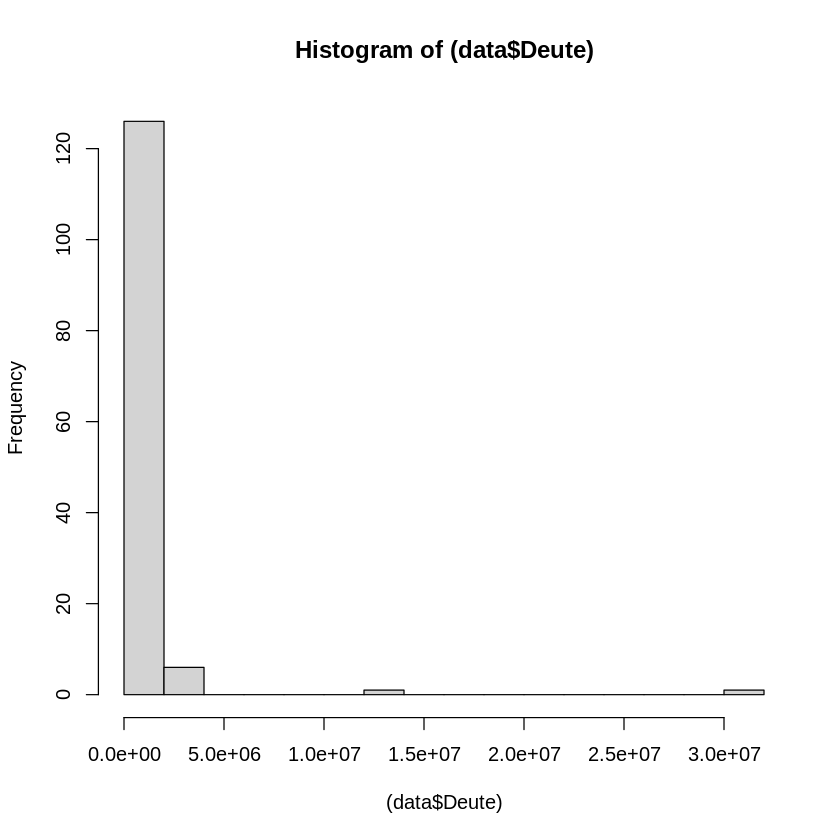

In [186]:
# La deixarem tal com està.

# Mirem la columna Deute:
hist((data$Deute), breaks=15)

In [187]:
# Només tenim els dos següents valors extrems:
data[which(data$Deute > 1e7), ]

,Continent,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
China,Asia,220.17,13854168,9828,-1140350,Moderat,16418615,Moderat,Baix
Estados Unidos,Americas,1256.67,30429116,90797,-1811546,Baix,25629842,Baix,Baix


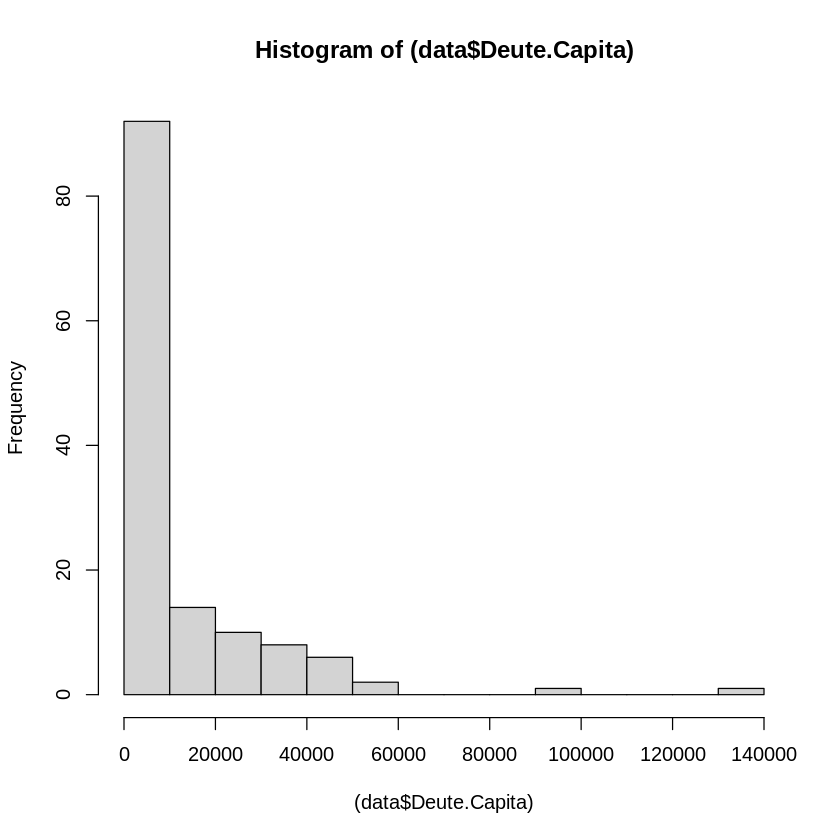

In [188]:
# Mirem el deute per càpita:
hist((data$Deute.Capita), breaks=15)

In [189]:
# Tenim els països seguents:
data[which(data$Deute.Capita > 80000), ]

,Continent,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
Estados Unidos,Americas,1256.67,30429116,90797,-1811546,Baix,25629842,Baix,Baix
Singapur,Asia,NA,821316,138783,16356,Baix,463607,Baix,Baix


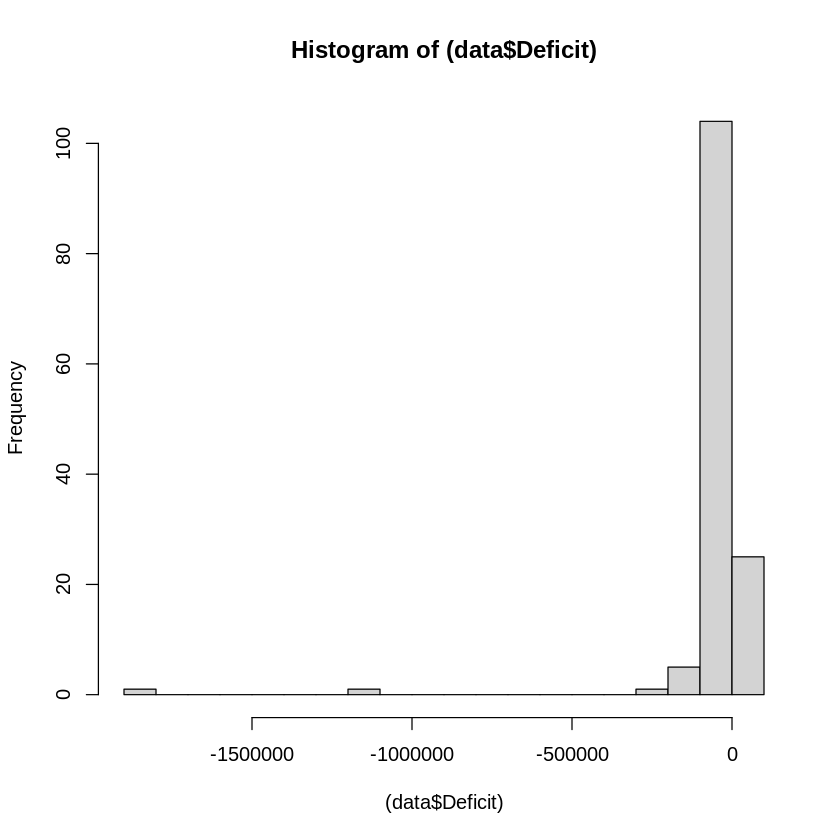

In [190]:
# Mirem el dèficit:
hist((data$Deficit), breaks=15)

In [191]:
data[which(data$Deficit < -500000), ]

,Continent,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
China,Asia,220.17,13854168,9828,-1140350,Moderat,16418615,Moderat,Baix
Estados Unidos,Americas,1256.67,30429116,90797,-1811546,Baix,25629842,Baix,Baix


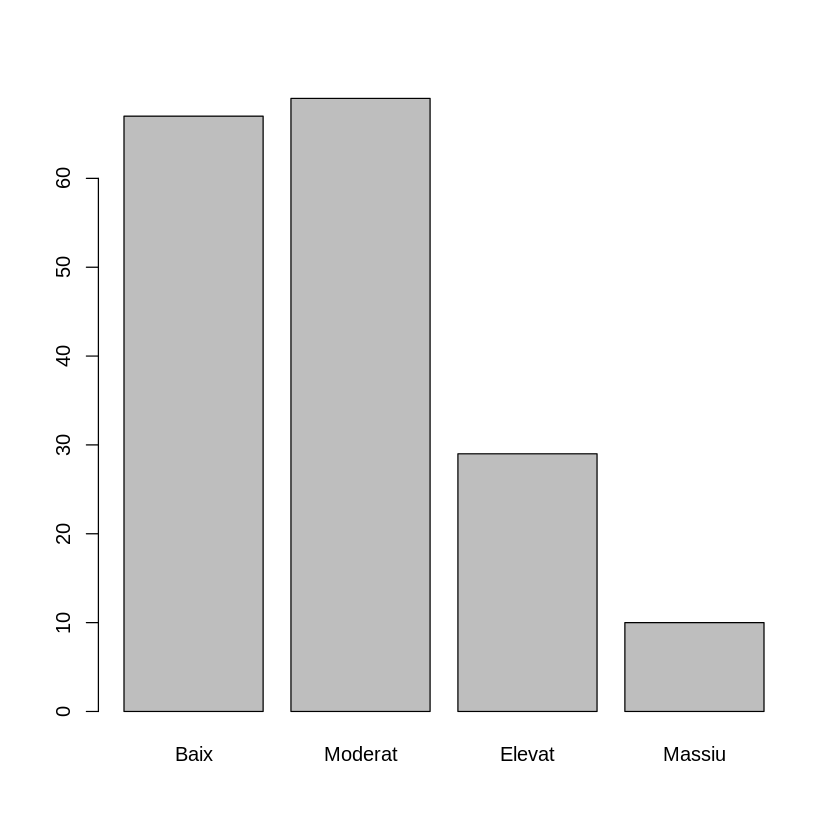

In [192]:
# Mirem l'atur:
barplot(table(data$Atur))

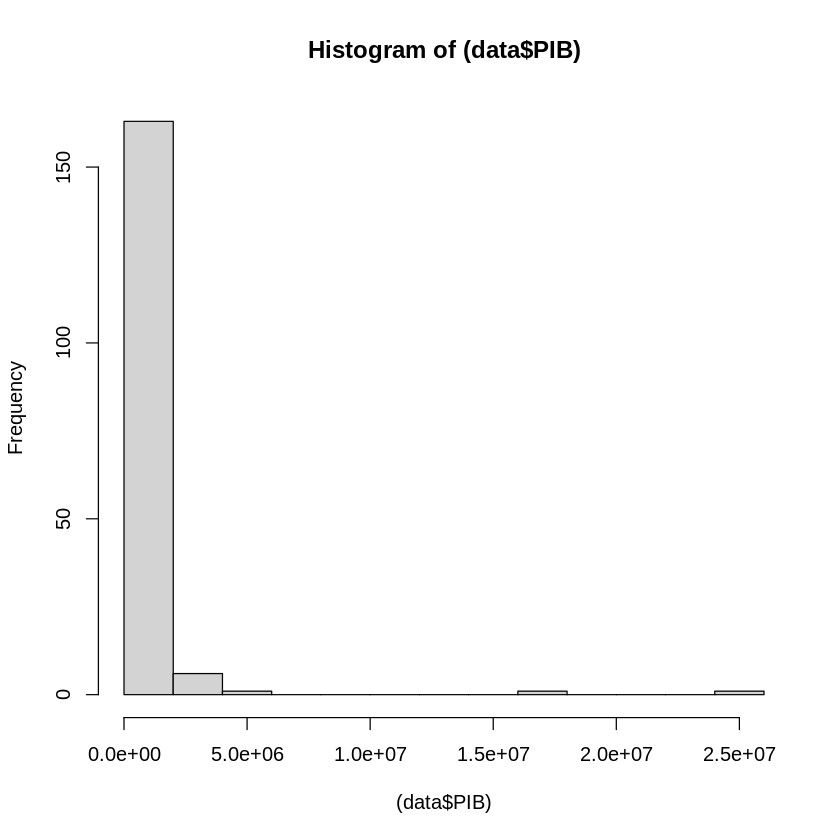

In [193]:
# Mirem el PIB:
hist((data$PIB), breaks=15)

In [194]:
data[which(data$PIB > 1e7), ]

,Continent,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
China,Asia,220.17,13854168,9828,-1140350,Moderat,16418615,Moderat,Baix
Estados Unidos,Americas,1256.67,30429116,90797,-1811546,Baix,25629842,Baix,Baix


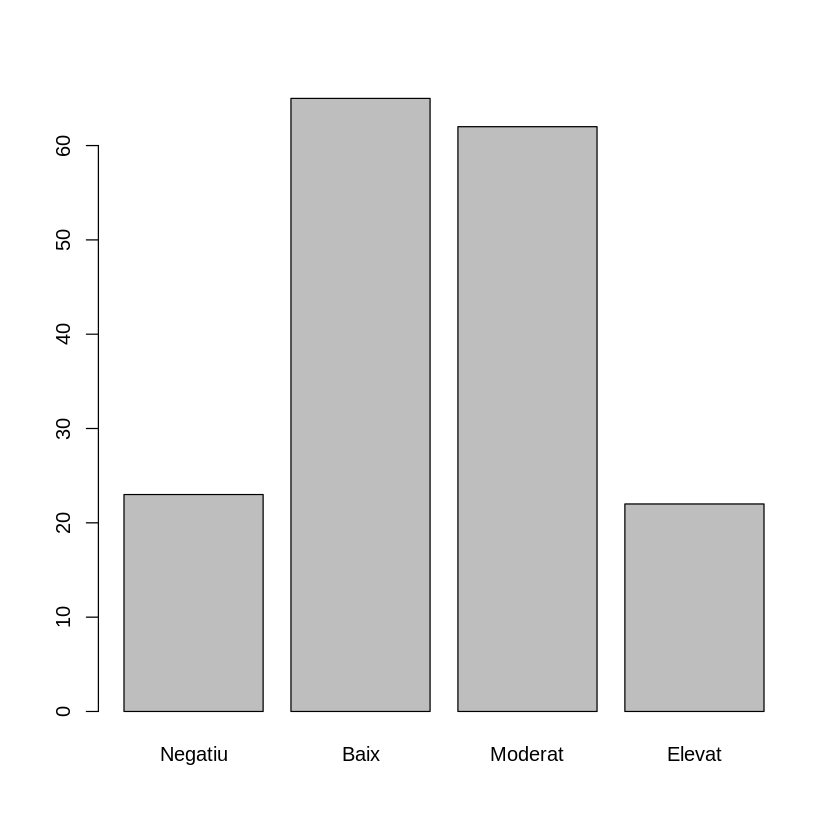

In [195]:
# Mirem la variació del PIB:
barplot(table(data$PIB.Var))

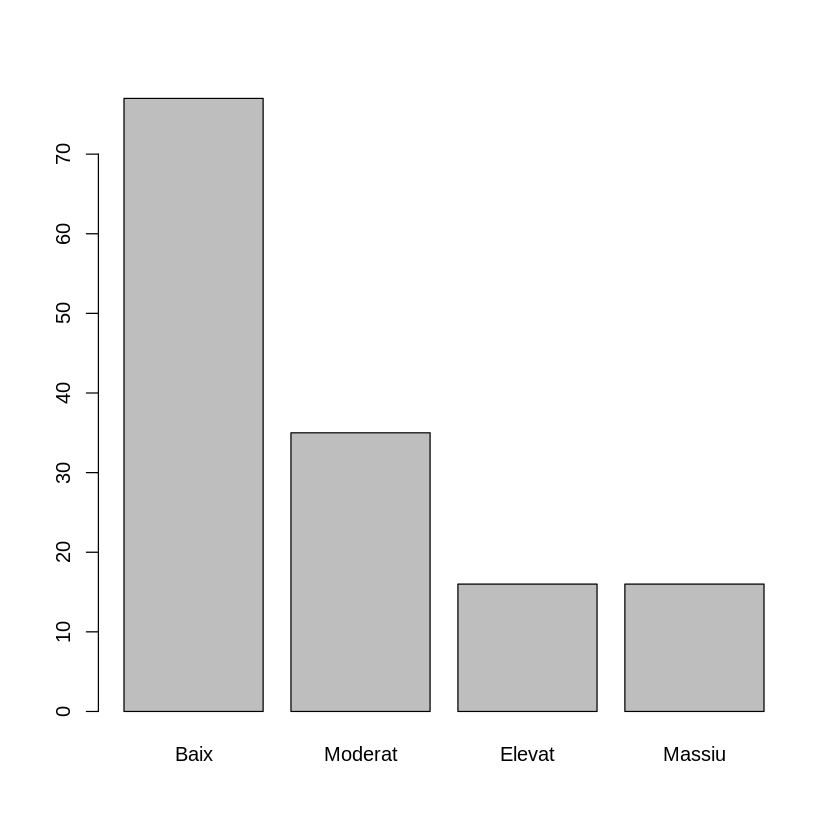

In [196]:
# Mirem l'IPC:
barplot(table(data$IPC))

In [197]:
# Per tant, els valors que podríem considerar Outliers en alguna de les
# categories són Estats Units, China i Singapur.

# Com que són pocs, eliminem els valors outliers.
data$PIB[data$PIB > 1e7] <- NA
data$Deficit[data$Deficit < -500000] <- NA
data$Deute.Capita[data$Deute.Capita > 80000] <- NA

In [198]:
# Setejem les noves variables amb un mètdode, per exemple, el de
# missForest? Mitja?

# Si, i si et sembla be he mogut el que ja tenim i ho fem nomes despres
# de eliminar outliers, que te mes sentit que l'ordre de l'enunciat i aixi no ho fem dues vegades.

3.1 Omplir els 0s

In [199]:
# Amb les dades ja netes, el que queda per fer és aplicar alguns mètodes per
# tal de reduir la quantitat de valors nuls.

# Mirem quants valors nuls tenim:
colSums(is.na(data))
nrow(data)

Continent          SMI        Deute Deute.Capita      Deficit         Atur 
           0           29           41           43           40            0 
         PIB      PIB.Var          IPC 
           5            3           31

[1] 175

In [200]:
# Pel que fa al SMI, els valors nuls corresponen a països que no tenen
# SMI definit: o bé no tenen legislació al respecte, o bé hi ha alguns convenis,
# però això no és SMI. En aquests casos, no tindria tant sentit substituir els
# nuls per algun valor mitjà. Per tant, considerarem que el SMI és 0.
data[which(is.na(data$SMI)), ]$SMI <- 0

In [201]:
# Per la resta de valors, sí que farem imputació de valors buits. Notem que ja
# hem millorat molt la presència de nuls en l'apartat anterior, ja que les
# columnes atur, IPC i SMI les hem canviat per valors nous, fiables i més
# complets. Així, les correccions que fem amb diversos mètodes seran més
# acurades, tenim més valors de referència correctes.

In [202]:
# Ja podem començar amb la imputació de valors buits, ho farem amb missForest.
# Fem la susbstitució usant la informació de totes les columnes, pero guardem
# els resultats a una nova variable data_no_NA:
data_no_NA <- missForest(data)$ximp

In [203]:
# Creem un dataset data_final sense modificar l'original, però no alterem
# de moment el conjunt data amb valors nuls.

# Ens interessa guardar el conjunt amb valors nuls, ja que per a l'aprenentatge
# supervisat, quan fem la divisió en conjunts de train i test, no volem
# que informació de les dades de train passi a les dades de test. Aleshores
# farem la divisió primer, i completarem els nuls per separat.
data_final <- data_no_NA

In [204]:
head(data_final)

,Continent,SMI,Deute,Deute.Capita,Deficit,Atur,PIB,PIB.Var,IPC
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
Afganistán,Asia,71.50,9620.175,2511.135,-218.000,Elevat,16022,Baix,Baix
Albania,Europe,386.42,42278.940,7045.570,-4544.765,Elevat,21255,Moderat,Elevat
Alemania,Europe,2544.08,2631777.000,31539.000,-107522.000,Baix,4185550,Negatiu,Baix
Andorra,Europe,1521.08,1255.000,14747.000,79.000,Baix,3448,Baix,Moderat
Angola,Africa,55.25,115161.020,2113.010,-8773.780,Moderat,82929,Baix,Elevat
Antigua y Barbuda,Americas,526.42,1452.000,14375.000,-32.000,Elevat,1880,Moderat,Baix


In [205]:
# Comprovem que ja no tenim nuls:
colSums(is.na(data_final))

Continent          SMI        Deute Deute.Capita      Deficit         Atur 
           0            0            0            0            0            0 
         PIB      PIB.Var          IPC 
           0            0            0

In [206]:
# A continuació, fem un resum de les dades finals:
summary(data_final)

    Continent       SMI             Deute           Deute.Capita  
 Africa  :53   Min.   :   0.0   Min.   :     239   Min.   :  180  
 Americas:34   1st Qu.:  48.8   1st Qu.:   10112   1st Qu.: 1846  
 Asia    :47   Median : 167.9   Median :   36704   Median : 4184  
 Europe  :41   Mean   : 420.6   Mean   :  557583   Mean   : 9664  
               3rd Qu.: 499.4   3rd Qu.:  156874   3rd Qu.:11979  
               Max.   :3096.8   Max.   :30429116   Max.   :53103  
    Deficit               Atur         PIB             PIB.Var        IPC    
 Min.   :-274433.0   Baix   :67   Min.   :    605   Negatiu:23   Baix   :90  
 1st Qu.:  -7125.4   Moderat:69   1st Qu.:  15076   Baix   :66   Moderat:40  
 Median :  -1897.0   Elevat :29   Median :  55385   Moderat:62   Elevat :23  
 Mean   : -13073.7   Massiu :10   Mean   : 355178   Elevat :24   Massiu :22  
 3rd Qu.:   -278.8                3rd Qu.: 320878                            
 Max.   :  73995.0                Max.   :4185550              

3.4 Altres mètodes

A part dels mètodes mencionats explícitament en l'apartat 3, en l'apartat 2 també hem aplicat alguns passos per a la neteja de dades.

- Hem eliminat algunes columnes que són redundants.
- Per exemple, hem canviat i simplificat el nom de les columnes.
- Hem eliminat els països d'Oceania, per tenir un equilibri en les variables objetiu.
- Hem eliminat files duplicades.
- Hem eliminat files completament buides.
- Hem ajuntat files corresponents al mateix pais per completar valors faltants.
- Hem buscat la informació corresponent a les columnes amb més nuls, modificant l'original per millorar la qualitat del conjunt de dades.
- Hem fet que el nom de la fila sigui el nom del pais.


In [207]:
# Creem un csv amb les dades finals
write.csv(data_final, "final_data.csv")

In [208]:
# Normalitzem aquí les dades a un rang (0, 1)? O a un rang (-1, 1)?
# Crec que podriem fer analisis no parametrics.

4. Anàlisi de dades

4.1 Aplicar un model supervisat i un model no supervisat.

Primer prepararem els conjunts d'entrenament i de test.

In [209]:
# Primer de tot, farem la divisió de les dades en un conjunt de test i de train:
train_ids <- createDataPartition(y=data$Continent, p=0.7, list=FALSE)
data_train <- data[train_ids,]
data_test <- data[-train_ids,]

In [210]:
# Comprovem que s'ha conservat la proporció de continents en cada conjunt:
table(data$Continent) / nrow(data) * 100
table(data_train$Continent) / nrow(data_train) * 100
table(data_test$Continent) / nrow(data_test) * 100


  Africa Americas     Asia   Europe 
30.28571 19.42857 26.85714 23.42857 


  Africa Americas     Asia   Europe 
30.64516 19.35484 26.61290 23.38710 


  Africa Americas     Asia   Europe 
29.41176 19.60784 27.45098 23.52941 

In [211]:
# Recordem que no hem fet la substitució dels valors nuls, ara és el
# moment de fer-ho amb els conjunts separats. Així no introduïm biaix a les
# dades.
colSums(is.na(data_train))
data_train_noNA <- missForest(data_train)$ximp
cols = c( 'Deute', 'Deute.Capita', 'Deficit', 'Atur', 'PIB', 'PIB.Var', 'IPC')
data_train[,cols] <- data_train_noNA[,cols]
colSums(is.na(data_train))

Continent          SMI        Deute Deute.Capita      Deficit         Atur 
           0            0           32           33           30            0 
         PIB      PIB.Var          IPC 
           4            3           21

Continent          SMI        Deute Deute.Capita      Deficit         Atur 
           0            0            0            0            0            0 
         PIB      PIB.Var          IPC 
           0            0            0

In [212]:
colSums(is.na(data_test))
data_test_noNA <- missForest(data_test)$ximp
cols = c( 'Deute', 'Deute.Capita', 'Deficit', 'Atur', 'PIB', 'PIB.Var', 'IPC')
data_test[,cols] <- data_test_noNA[,cols]
colSums(is.na(data_test))

Continent          SMI        Deute Deute.Capita      Deficit         Atur 
           0            0            9           10           10            0 
         PIB      PIB.Var          IPC 
           1            0           10

Continent          SMI        Deute Deute.Capita      Deficit         Atur 
           0            0            0            0            0            0 
         PIB      PIB.Var          IPC 
           0            0            0

In [213]:
# Ara augmentarem les classes minoritàries i que totes tinguin un nombre
# similar al d'Africa.
table(data_train$Continent)


  Africa Americas     Asia   Europe 
      38       24       33       29 

In [214]:
# Incrementem en 15 els exemples d'Americas
data_train <- dplyr::bind_rows(data_train, tail(smote(Continent ~ ., data_train, perc.over = 1, k = 5, perc.under = 0), n=15))

In [215]:
# Incrementem en 10 els exemples d'Europe
data_train <- dplyr::bind_rows(data_train, tail(smote(Continent ~ ., data_train, perc.over = 1, k = 5, perc.under = 0), n=10))

In [216]:
# Incrementem en 6 els exemples d'Asia
data_train <- dplyr::bind_rows(data_train, tail(smote(Continent ~ ., data_train, perc.over = 1, k = 5, perc.under = 0), n=6))

In [217]:
# Incrementem en 1 els exemples d'Africa
data_train <- dplyr::bind_rows(data_train, tail(smote(Continent ~ ., data_train, perc.over = 1, k = 5, perc.under = 0), n=1))

In [218]:
table(data_train$Continent)


  Africa Americas     Asia   Europe 
      39       39       39       39 

In [219]:
# Fem el mateix pel conjunt de test:
table(data_test$Continent)


  Africa Americas     Asia   Europe 
      15       10       14       12 

In [220]:
# Incrementem en 6 els exemples d'Americas
data_test <- dplyr::bind_rows(data_test, tail(smote(Continent ~ ., data_test, perc.over = 1, k = 5, perc.under = 0), n=6))

In [221]:
# Incrementem en 4 els exemples d'Europe
data_test <- dplyr::bind_rows(data_test, tail(smote(Continent ~ ., data_test, perc.over = 1, k = 5, perc.under = 0), n=4))

In [222]:
# Incrementem en 2 els exemples d'Asia
data_test <- dplyr::bind_rows(data_test, tail(smote(Continent ~ ., data_test, perc.over = 1, k = 5, perc.under = 0), n=2))

In [223]:
# Incrementem en 1 els exemples d'Africa
data_test <- dplyr::bind_rows(data_test, tail(smote(Continent ~ ., data_test, perc.over = 1, k = 5, perc.under = 0), n=1))

In [224]:
table(data_test$Continent)


  Africa Americas     Asia   Europe 
      16       16       16       16 

In [225]:
# Ara separem la variable a predir, Continent:
X_train <- subset(data_train, select = -Continent )
y_train <- data_train['Continent']
X_test <- subset(data_test, select = -Continent )
y_test <- data_test['Continent']

In [226]:
# Aquest conjunts ja els podem usar tant per al model supervisat com per
# al no supervisat.

In [227]:
# COMENTARI: NORMALITZEM LES DADES O NO?
# en teoria no fa falta les dades normalitzades per aplicar models no?

# No és necessari, però és recomanable, ho podem deixar com està.

A. Model supervisat

In [228]:
# El primer que farem serà aplicar un model randomForest.

In [229]:
# Creem el model amb 500 arbres, i la data d'entrenament:
rf_model <- randomForest(Continent~., data_train, ntree = 500)

In [230]:
# Mirem la importància de cada atribut. Sembla que el Deute.Capita i SMI
# són els valors més alts.
importance(rf_model)

,MeanDecreaseGini
SMI,21.262086
Deute,13.393629
Deute.Capita,28.754940
Deficit,13.060360
Atur,6.116561
PIB,15.403971
PIB.Var,9.467616
IPC,8.128185


In [231]:
# Apliquem el model a les dades d'entrenament.
rf_pred_train <- predict(rf_model, data_train)
confusionMatrix(rf_pred_train, data_train$Continent)

Confusion Matrix and Statistics

          Reference
Prediction Africa Americas Asia Europe
  Africa       39        0    0      0
  Americas      0       39    0      0
  Asia          0        0   39      0
  Europe        0        0    0     39

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9766, 1)
    No Information Rate : 0.25       
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: Africa Class: Americas Class: Asia Class: Europe
Sensitivity                   1.00            1.00        1.00          1.00
Specificity                   1.00            1.00        1.00          1.00
Pos Pred Value                1.00            1.00        1.00          1.00
Neg Pred Value                1.00            1.00        1

In [232]:
# Com és d'esperar, s'han obtingut resultats perfectes amb les dades
# d'entrenament. Sabem que els models basats en DecisionTrees són propensos
# a l'overfitting.

In [233]:
# Mirem que passa amb les dades de test:
rf_pred_test <- predict(rf_model, data_test)
confusionMatrix(rf_pred_test, data_test$Continent)

Confusion Matrix and Statistics

          Reference
Prediction Africa Americas Asia Europe
  Africa       11        0    5      0
  Americas      4       10    3      1
  Asia          1        3    6      5
  Europe        0        3    2     10

Overall Statistics
                                          
               Accuracy : 0.5781          
                 95% CI : (0.4482, 0.7006)
    No Information Rate : 0.25            
    P-Value [Acc > NIR] : 2.472e-08       
                                          
                  Kappa : 0.4375          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Africa Class: Americas Class: Asia Class: Europe
Sensitivity                 0.6875          0.6250     0.37500        0.6250
Specificity                 0.8958          0.8333     0.81250        0.8958
Pos Pred Value              0.6875          0.5556     0.40000        0.6667
Neg Pred Value

In [234]:
# Aconseguim predir correctament una mica més de la meitat dels paisos.

In [235]:
# Ara provarem un altre model supervisat, Support-Vector Machines.
# Creem el model:
svm_model = svm(formula = Continent~.,
                data = data_train,
                type = 'C-classification',
                kernel = 'linear')

In [236]:
# L'apliquem a les dades d'entrenament:
svm_pred_train <- predict(svm_model, data_train)
confusionMatrix(svm_pred_train, data_train$Continent)

Confusion Matrix and Statistics

          Reference
Prediction Africa Americas Asia Europe
  Africa       33        4    4      1
  Americas      1       26    4      3
  Asia          5        4   28      6
  Europe        0        5    3     29

Overall Statistics
                                          
               Accuracy : 0.7436          
                 95% CI : (0.6676, 0.8101)
    No Information Rate : 0.25            
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6581          
                                          
 Mcnemar's Test P-Value : 0.6212          

Statistics by Class:

                     Class: Africa Class: Americas Class: Asia Class: Europe
Sensitivity                 0.8462          0.6667      0.7179        0.7436
Specificity                 0.9231          0.9316      0.8718        0.9316
Pos Pred Value              0.7857          0.7647      0.6512        0.7838
Neg Pred Value

In [237]:
# No obtenim uns resultats tant bons com amb RandomForest.

In [238]:
# Veiem que passa amb el conjunt de test:
svm_pred_test <- predict(svm_model, data_test)
confusionMatrix(svm_pred_test, data_test$Continent)

Confusion Matrix and Statistics

          Reference
Prediction Africa Americas Asia Europe
  Africa       13        0    5      0
  Americas      1        7    2      2
  Asia          2        6    8      4
  Europe        0        3    1     10

Overall Statistics
                                          
               Accuracy : 0.5938          
                 95% CI : (0.4637, 0.7149)
    No Information Rate : 0.25            
    P-Value [Acc > NIR] : 5.75e-09        
                                          
                  Kappa : 0.4583          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Africa Class: Americas Class: Asia Class: Europe
Sensitivity                 0.8125          0.4375      0.5000        0.6250
Specificity                 0.8958          0.8958      0.7500        0.9167
Pos Pred Value              0.7222          0.5833      0.4000        0.7143
Neg Pred Value

In [239]:
# Tenim uns resultats molt similars als obtinguts amb RandomForest.

B. Model no supervisat

In [240]:
# Per fer un model no supervisat en farem us del mètode de mètodes de partició
# per determinar si segons les propietats dels diferents valors numèrics són
# suficients per determinar si el continent el qual es representat es pot formar
# un cluster sobre aquest

In [241]:
# Primer de tot crearem un conjunt amb el total de valors numerics sense el
# continent
 data_to_cluster <- data_final[,c("SMI","Deute","Deute.Capita","Deficit","PIB")]

In [242]:
# Un cop amb aquestes dades es pot aplicar el kmeans i k = 4 sent el numero de
# clusters que volem crear
kmeans.res <- kmeans(data_to_cluster,4)

In [243]:
# Un cop tenim els camps en clusters, calcularem quins seràn els clusters reals
# comparats amb els continents

table(data_final$Continent, kmeans.res$cluster)

          
            1  2  3  4
  Africa   53  0  0  0
  Americas 31  0  1  2
  Asia     44  2  0  1
  Europe   35  1  0  5

In [244]:
# Un cop tenim els camps en clusters, calcularem quins seràn els clusters reals
# comparats amb els continents

table(data_final$PIB.Var, kmeans.res$cluster)

         
           1  2  3  4
  Negatiu 22  0  0  1
  Baix    57  2  1  6
  Moderat 61  1  0  0
  Elevat  23  0  0  1

In [245]:
# Ho farem igualment per l'atur
table(data_final$Atur, kmeans.res$cluster)

         
           1  2  3  4
  Baix    62  2  1  2
  Moderat 63  1  0  5
  Elevat  28  0  0  1
  Massiu  10  0  0  0

In [246]:
# Ho fem igualment per l'IPC
table(data_final$IPC, kmeans.res$cluster)

         
           1  2  3  4
  Baix    79  3  1  7
  Moderat 39  0  0  1
  Elevat  23  0  0  0
  Massiu  22  0  0  0

In [247]:
# Veiem que per a aquest mètode no supervisat, de clustering, no arriba a fer
# cluster correcte del continent segons les dades numeriques que hem
# proporcionat, aquestes sent el SMI, el Deute, el deute per càpita, el dèficit
# i el PIB

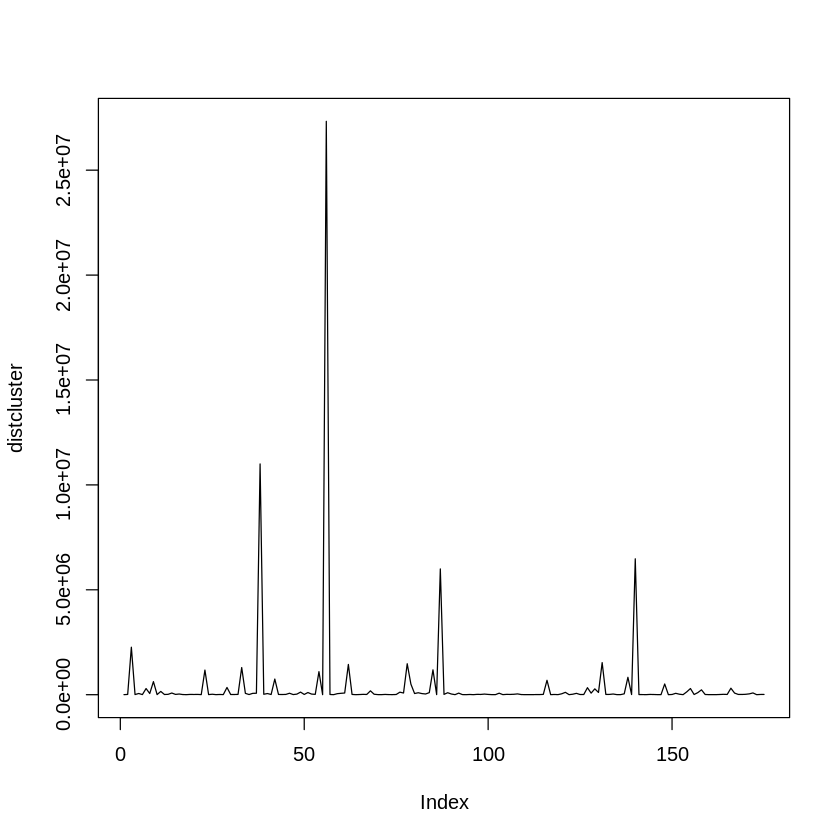

In [248]:
# Farem servir igualment un altre tipus de model no supervisat, aquest sent
# aquests mètodes basats en la densitat de veïnts.
# Per això farem servir el mètode dbscan

#Primer de tot haurem de calucalr quin es el valor de eps, que es el que es
# defineix com la distancia promitja a la que haurien d'estar punts d'un
# matiex cluster
distcluster <- dbscan::kNNdist(data_to_cluster, k = 5)

# Graficar las distancias para observar el codo
plot(distcluster, type = "l")

In [249]:
# Veiem que hi ha dos punts on es podría explicitar els dos valors de eps, per
# tant, ho probarem amb els dos

In [250]:
dbscan.result <- dbscan(data_to_cluster, eps = 90000, minPts = 2)
dbscan.result
table(data_final$Continent, dbscan.result$cluster)
table(data_final$Atur, dbscan.result$cluster)
table(data_final$IPC, dbscan.result$cluster)

DBSCAN clustering for 175 objects.
Parameters: eps = 90000, minPts = 2
Using euclidean distances and borderpoints = TRUE
The clustering contains 2 cluster(s) and 26 noise points.

  0   1   2 
 26 147   2 

Available fields: cluster, eps, minPts, metric, borderPoints

          
            0  1  2
  Africa    1 52  0
  Americas  5 29  0
  Asia      8 37  2
  Europe   12 29  0

         
           0  1  2
  Baix    14 52  1
  Moderat 11 57  1
  Elevat   1 28  0
  Massiu   0 10  0

         
           0  1  2
  Baix    22 67  1
  Moderat  1 39  0
  Elevat   1 22  0
  Massiu   2 19  1

In [251]:
# Veiem amb aquest mètode tampoc hem aconseguit agrupar correctament les dades
# pel que es podría confirmar que aquestes variables no segueixen una
# distribucuó de clustering segons els diferents paràmteres que tenin al
# dataset

4.2 proba de contrast d'hipotesis

In [252]:
# Volem fer ara un contrast d'hipòtesis sobre com el PIB es veu influit pel
# nivell d'atur del pais.

# Veient les dades, veiem que les dades no segueixen una distribució normal
# hem de compovar que les distribucions es troben en un altre distribució.

shapiro.test(data_final$PIB)


	Shapiro-Wilk normality test

data:  data_final$PIB
W = 0.51236, p-value < 2.2e-16


In [253]:
# Veiem que ambdos camp de PIB no compleixen distribucions normals,
# ja que el p-value < 0.05 fent que podem rebutjar la hipòtesi que aquesta
# variable segueix una distribució normal.


# Per comprovar l’homoscedasticitat d'aquesta variable no té una homogeneitat
# de variançes.

In [254]:
fligner.test(PIB ~ Atur, data = data_final)


	Fligner-Killeen test of homogeneity of variances

data:  PIB by Atur
Fligner-Killeen:med chi-squared = 31.271, df = 3, p-value = 7.456e-07


In [255]:
# Veiem que el p-value es menor de 0.05 pel que podem afirmar que per aquestes
# dades es faran tests no paramètrics, com el test de Wilcox. Si analitzem
# aquestes variables segons els diferents valors veiem:

In [256]:
wilcox.test(PIB ~ Atur, data = data_final, subset = Atur %in% c('Baix', 'Massiu'))
wilcox.test(PIB ~ Atur, data = data_final, subset = Atur %in% c('Baix', 'Elevat'))
wilcox.test(PIB ~ Atur, data = data_final, subset = Atur %in% c('Baix', 'Moderat'))


	Wilcoxon rank sum test with continuity correction

data:  PIB by Atur
W = 507, p-value = 0.009355
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  PIB by Atur
W = 1487, p-value = 3.967e-05
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  PIB by Atur
W = 2601, p-value = 0.2084
alternative hypothesis: true location shift is not equal to 0
